In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pmdarima as pm
import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

from pylab import rcParams
import warnings

In [2]:
print(np.__version__)

1.26.4


In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)
rcParams['figure.figsize'] = (18,7)

In [4]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

import os
import joblib

SAVE_DIR = "/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/"
os.makedirs(SAVE_DIR, exist_ok=True)

In [7]:
df_brl = CommodityLoader.load_all_commodities(
    currency='BRL',
    preprocessing=True,
    monthly_aggregation='mean',
    limit_date=None
)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [ ]:
series_test_sizes = {
    "ACUCAR_SANTOS": 20,
    "ACUCAR_SP": 80,
    "ALGODAO": 105,
    "ARROZ": 72,
    "CAFE_ARABICA": 104,
    "CAFE_ROBUSTA": 87,
    "MILHO": 75,
    "SOJA_PARANA": 101,
    "SOJA_PARANAGUA": 70,
    "TRIGO_PARANA": 77,
    "TRIGO_RS": 77
}

def train_and_rolling(df, ratio=0.3):
    df = df.sort_values('ds')
    uid = df['unique_id'].iloc[0]
    y = df['y'].values

    horizon = series_test_sizes[uid]
    train, test = y[:-horizon], y[-horizon:]

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    model = pm.auto_arima(
        train_scaled, 
        seasonal=True, 
        m=12, 
        stepwise=True,
        error_action='ignore', 
        suppress_warnings=True
    )
    params = model.order, model.seasonal_order

    print(f"Treino {uid}")
    print(f"Order {uid}: {[params[0]] * horizon}")
    print(f"Seasonal Order {uid}: {[params[1]] * horizon}")

    name = "arima_tunned"
    path = os.path.join(SAVE_DIR, name)
    joblib.dump(model, f"{path}_{uid}.pkl")
    print(f"Modelo arima salvo em: {path}.pkl")

    forecasts = []
    for obs in test_scaled:
        f = model.predict(n_periods=1)[0]
        forecasts.append(f)
        model.update([obs])

    y_true = scaler.inverse_transform(test_scaled.reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1)).flatten()

    return pd.DataFrame({
        'unique_id': uid,
        'order': [params[0]] * horizon,
        'seasonal_order': [params[1]] * horizon,
        'y_true': y_true,
        'y_pred': y_pred,
        'ds': df['ds'].iloc[-horizon:].values
    })

In [9]:
results = (
    df_brl
    .groupby('unique_id')
    .apply(train_and_rolling)
    .reset_index(drop=True)
)

Treino ACUCAR_SANTOS
Order ACUCAR_SANTOS: [(0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0)]
Seasonal Order ACUCAR_SANTOS: [(0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12)]
Treino ACUCAR_SP
Order ACUCAR_SP: [(0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1), (0, 1, 1

In [10]:
results.head()

,unique_id,order,seasonal_order,y_true,y_pred,ds
0,ACUCAR_SANTOS,"(0, 1, 0)","(0, 0, 0, 12)",176.677619,176.462642,2023-10-01
1,ACUCAR_SANTOS,"(0, 1, 0)","(0, 0, 0, 12)",172.731500,178.971537,2023-11-01
2,ACUCAR_SANTOS,"(0, 1, 0)","(0, 0, 0, 12)",149.326842,174.889769,2023-12-01
3,ACUCAR_SANTOS,"(0, 1, 0)","(0, 0, 0, 12)",154.029545,150.941207,2024-01-01
4,ACUCAR_SANTOS,"(0, 1, 0)","(0, 0, 0, 12)",157.357368,155.708223,2024-02-01


In [34]:
results.head()

,unique_id,order,seasonal_order,y_true,y_pred,ds
0,ACUCAR_SANTOS,"(0, 1, 0)","(0, 0, 0, 12)",176.677619,176.462642,2023-10-01
1,ACUCAR_SANTOS,"(0, 1, 0)","(0, 0, 0, 12)",172.731500,178.971537,2023-11-01
2,ACUCAR_SANTOS,"(0, 1, 0)","(0, 0, 0, 12)",149.326842,174.889769,2023-12-01
3,ACUCAR_SANTOS,"(0, 1, 0)","(0, 0, 0, 12)",154.029545,150.941207,2024-01-01
4,ACUCAR_SANTOS,"(0, 1, 0)","(0, 0, 0, 12)",157.357368,155.708223,2024-02-01


In [35]:
results.to_parquet('arima_prediction.parquet', index=False)

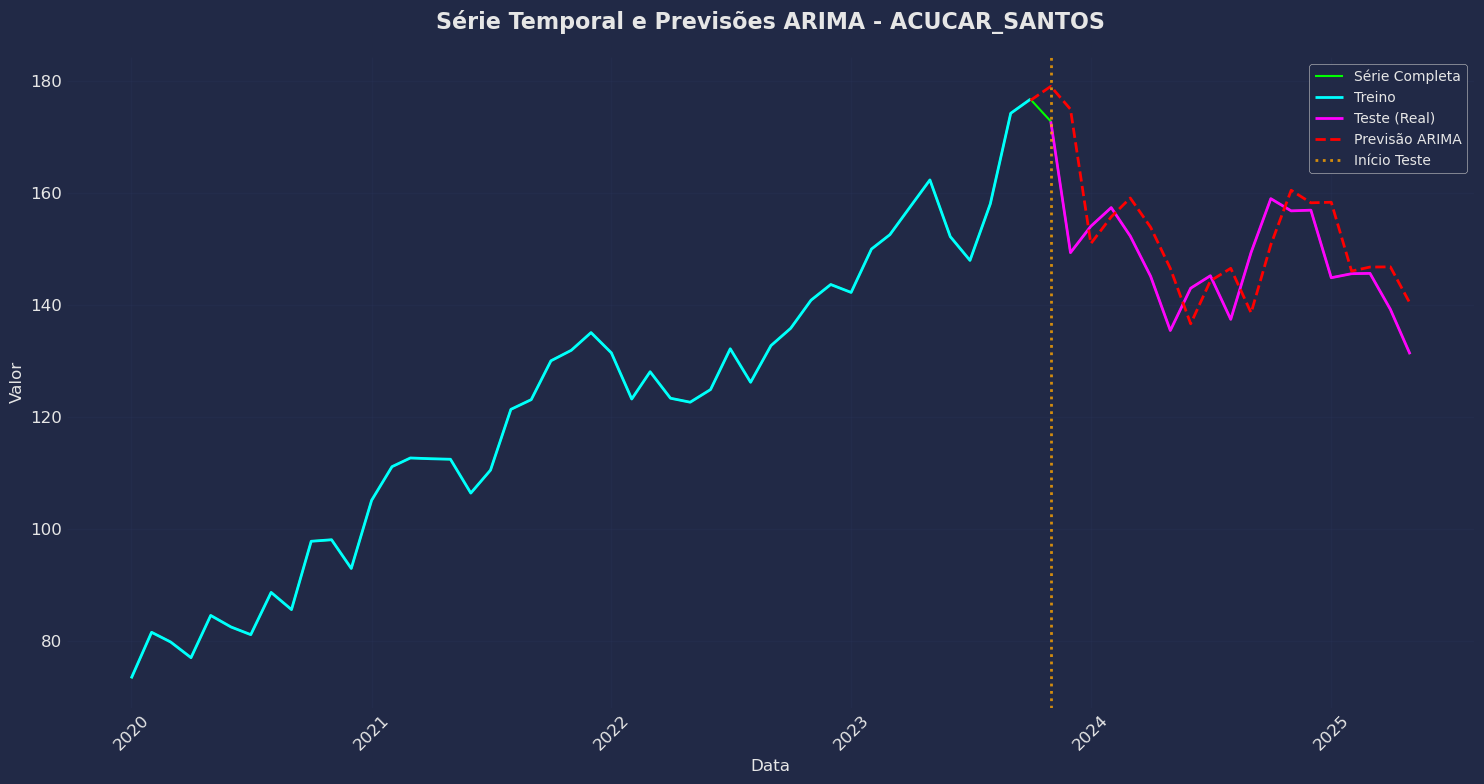

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


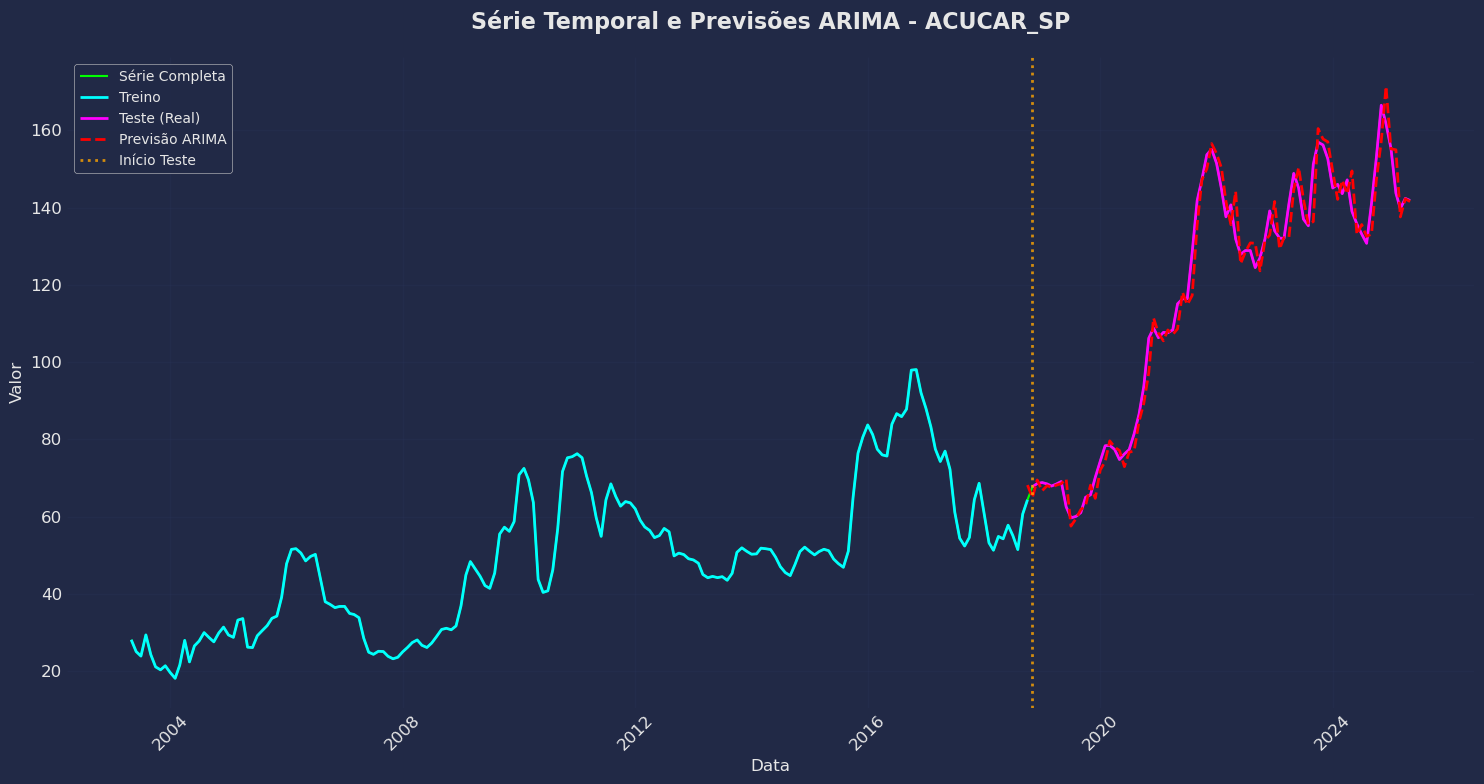

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


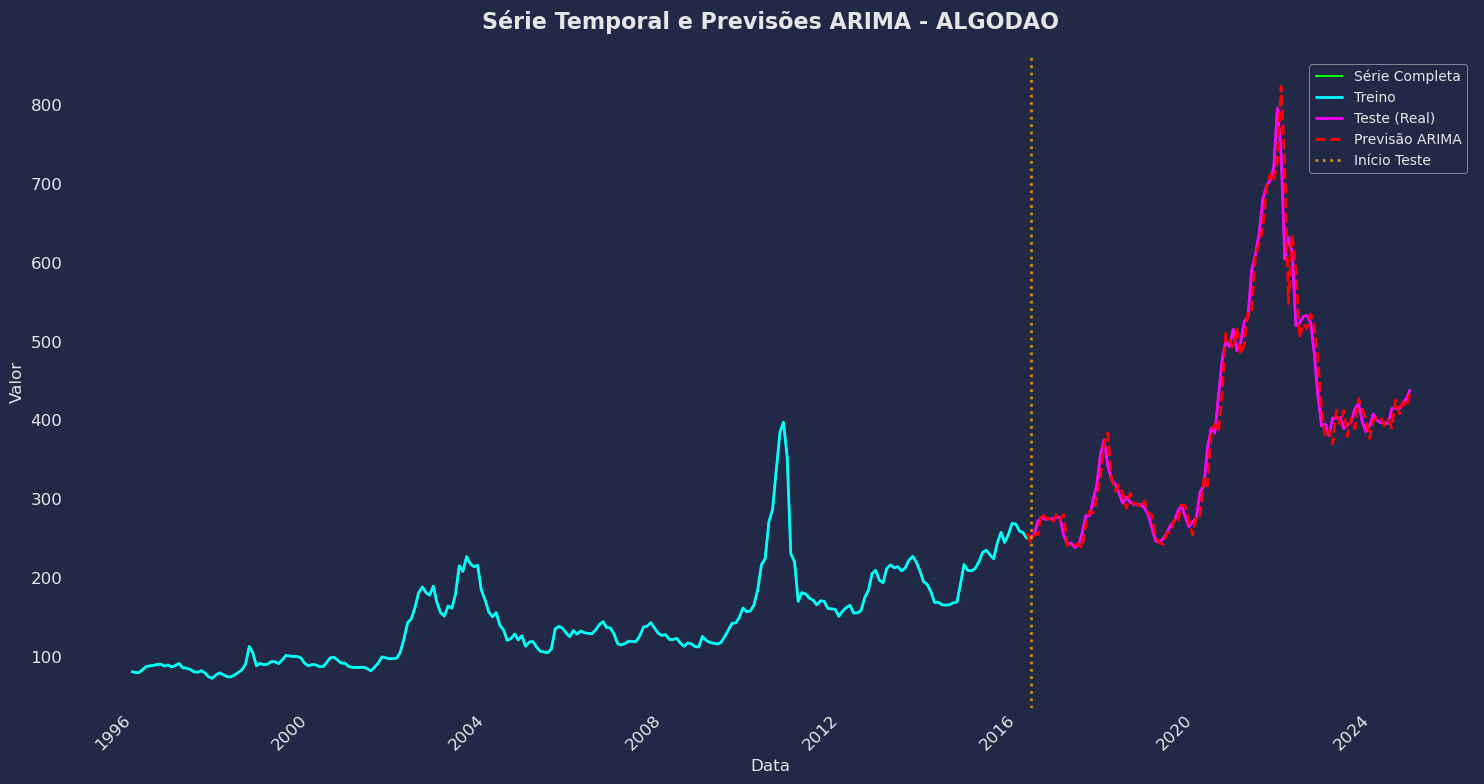

Gráfico exibido para: ALGODAO
--------------------------------------------------


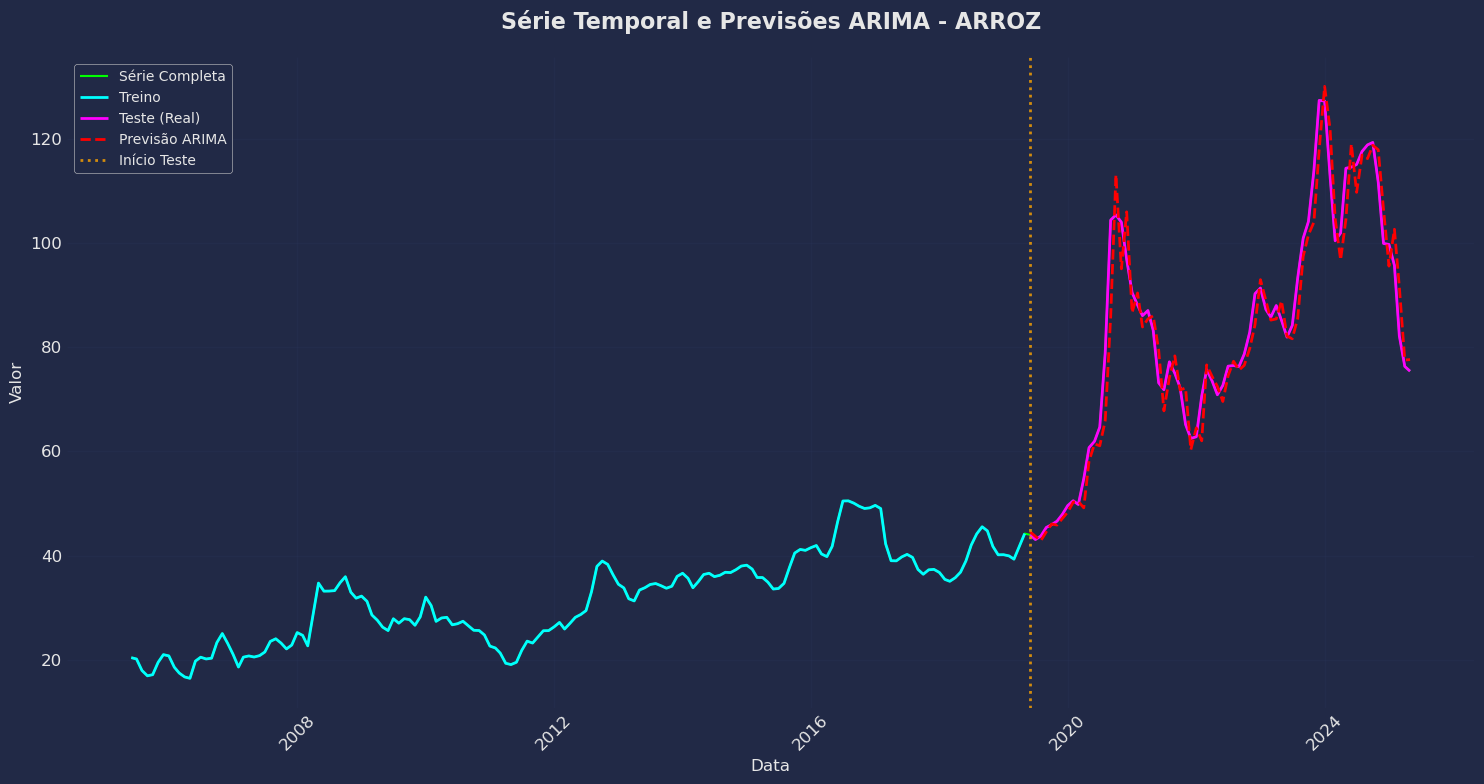

Gráfico exibido para: ARROZ
--------------------------------------------------


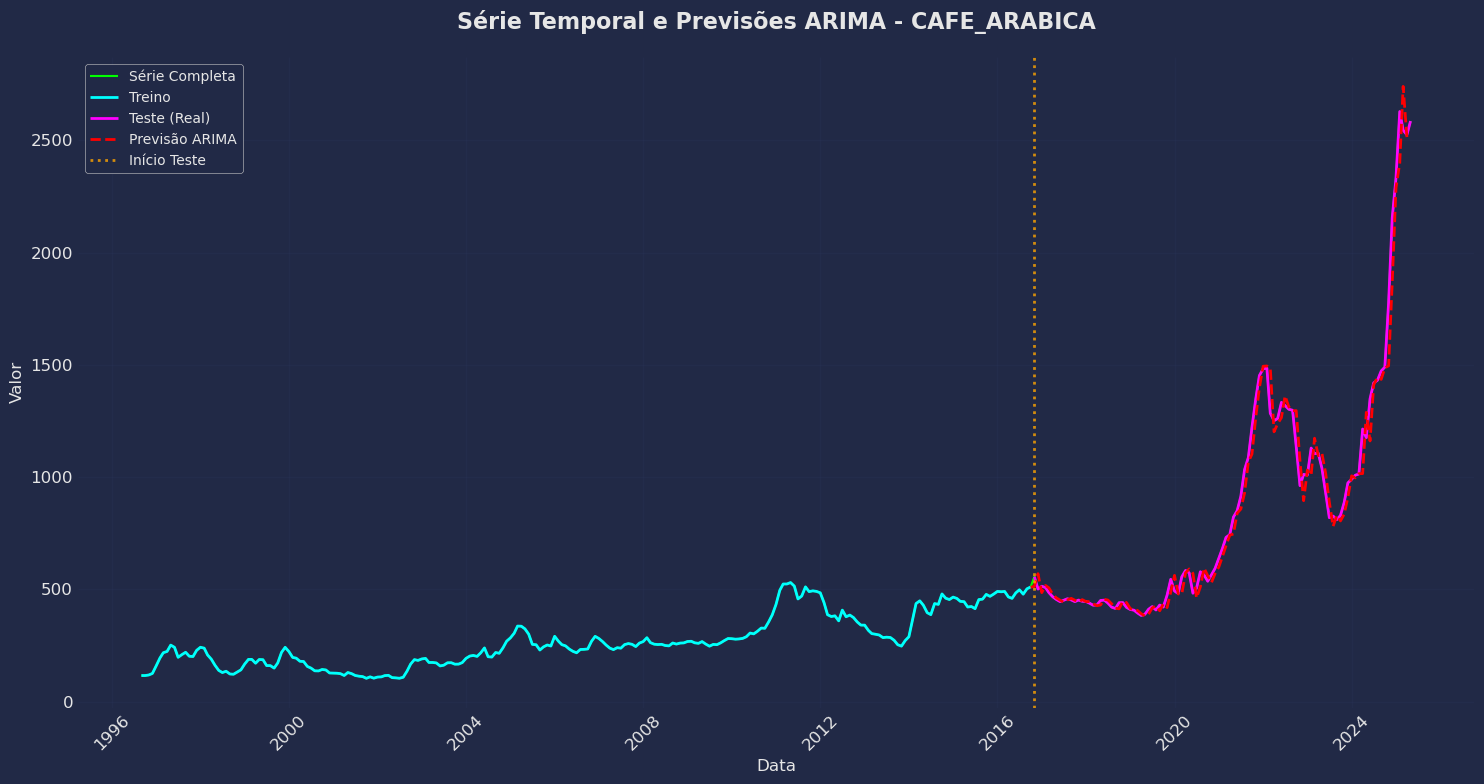

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


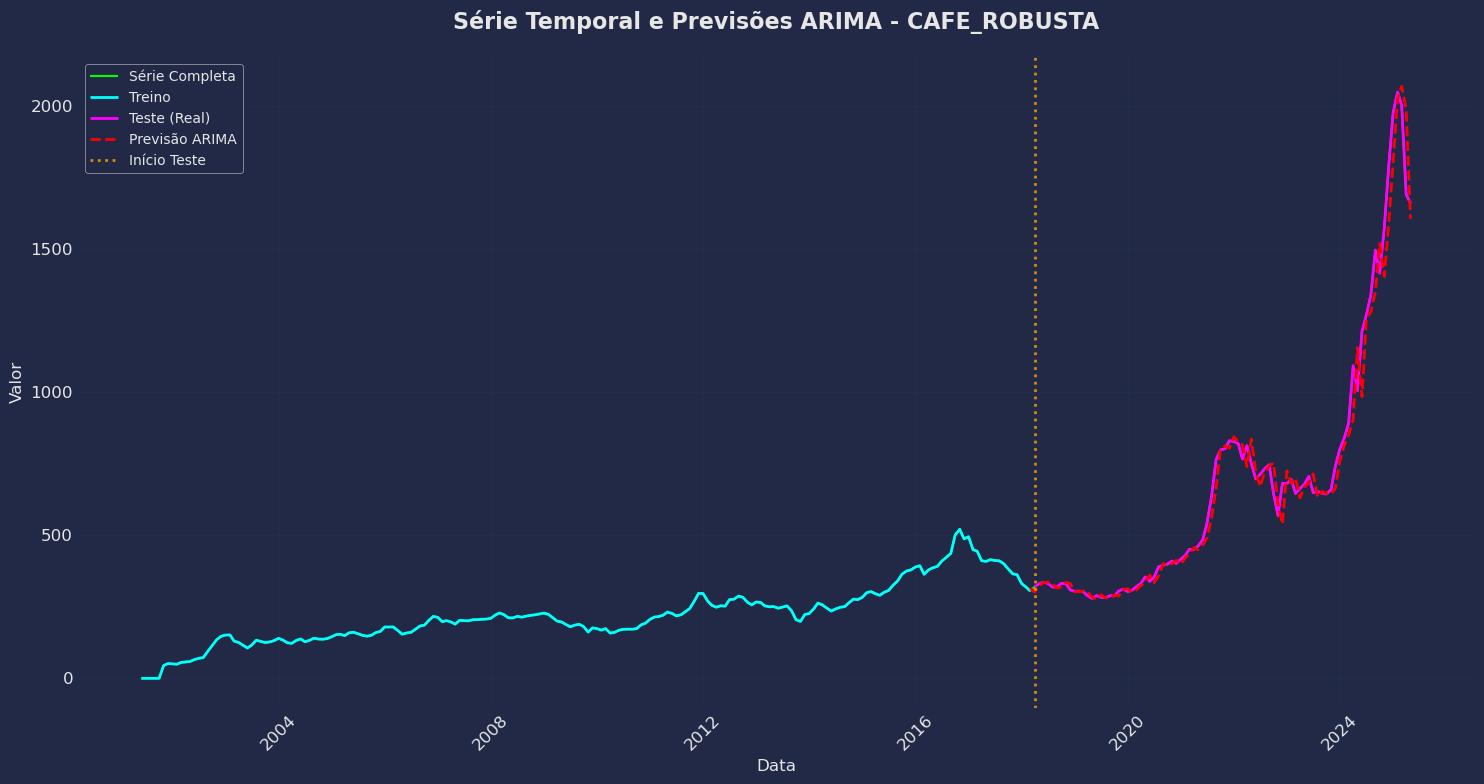

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


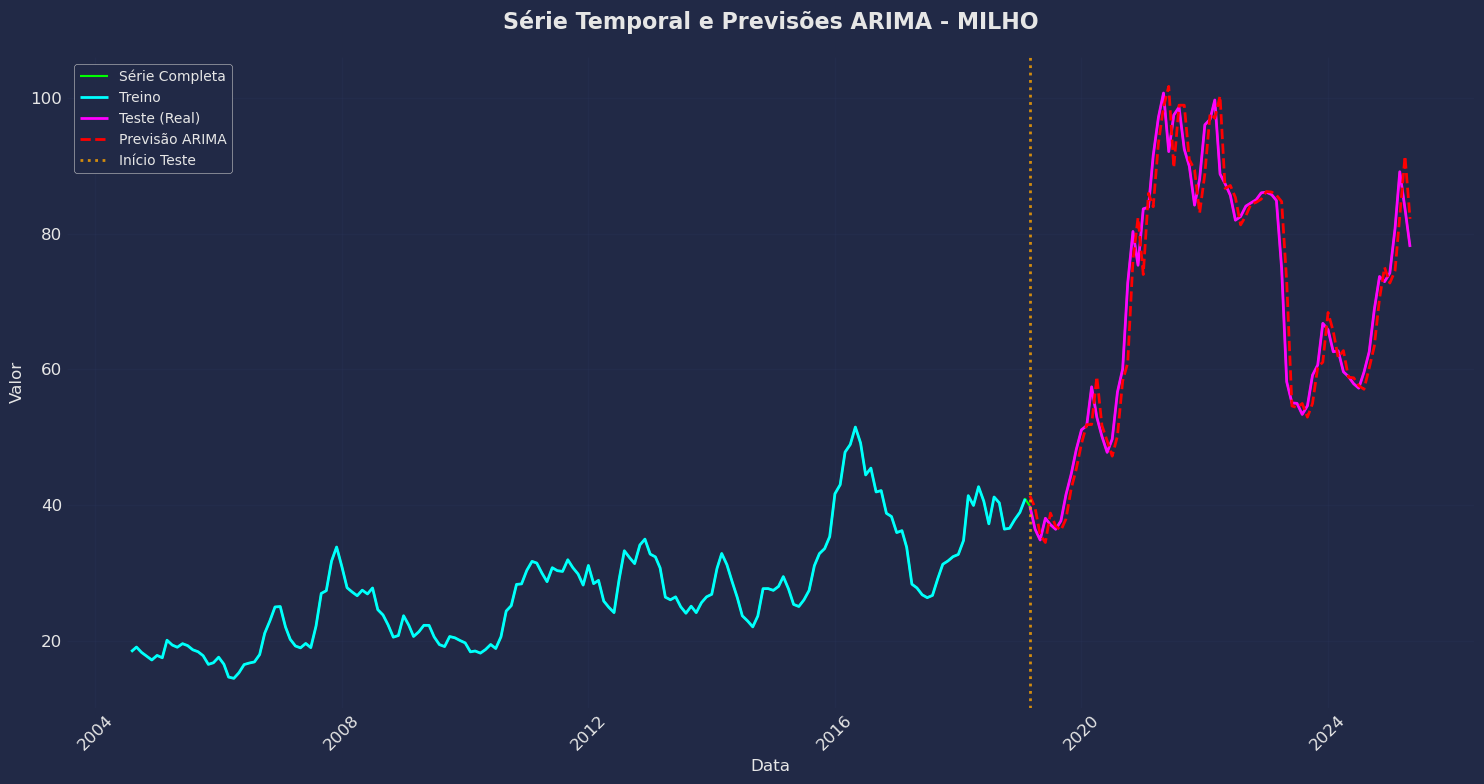

Gráfico exibido para: MILHO
--------------------------------------------------


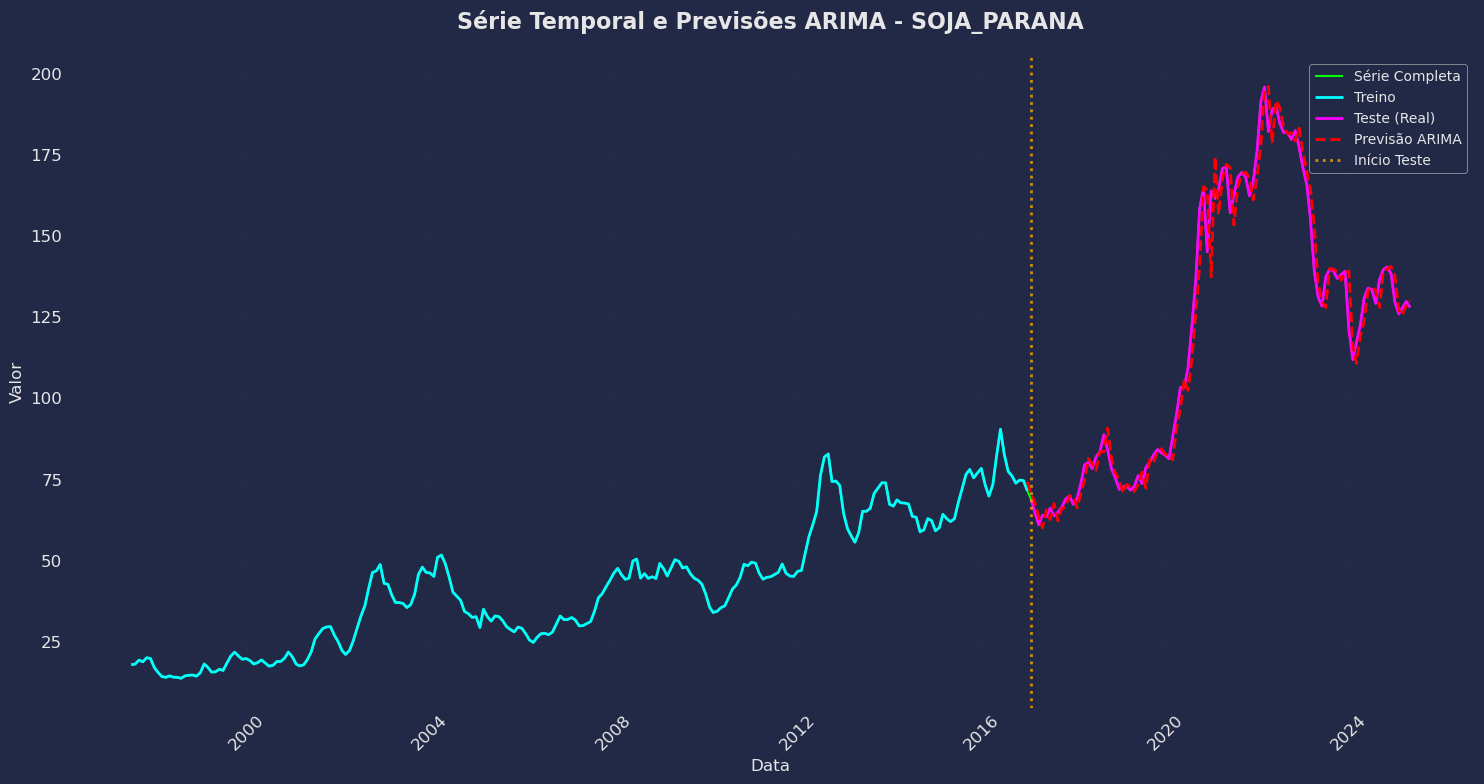

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


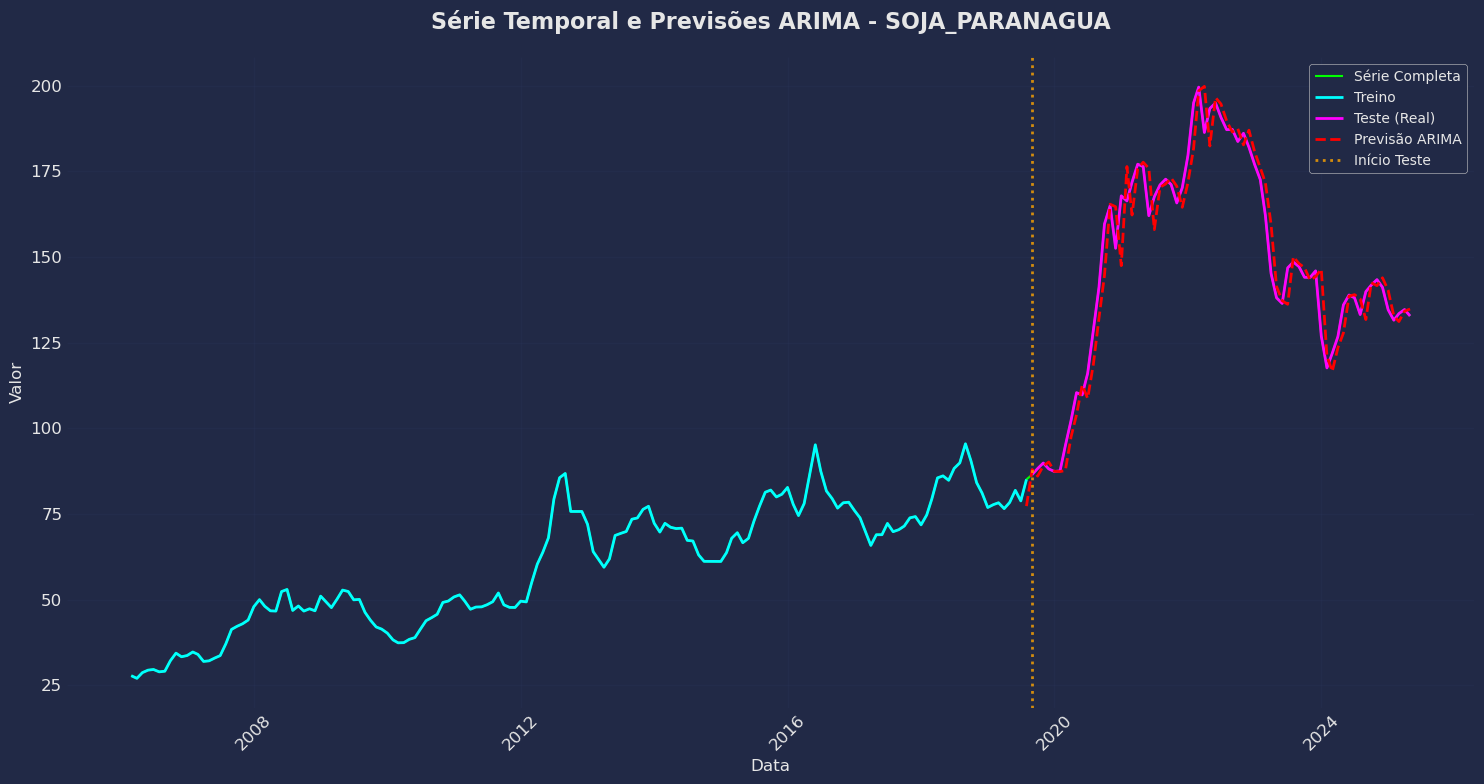

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


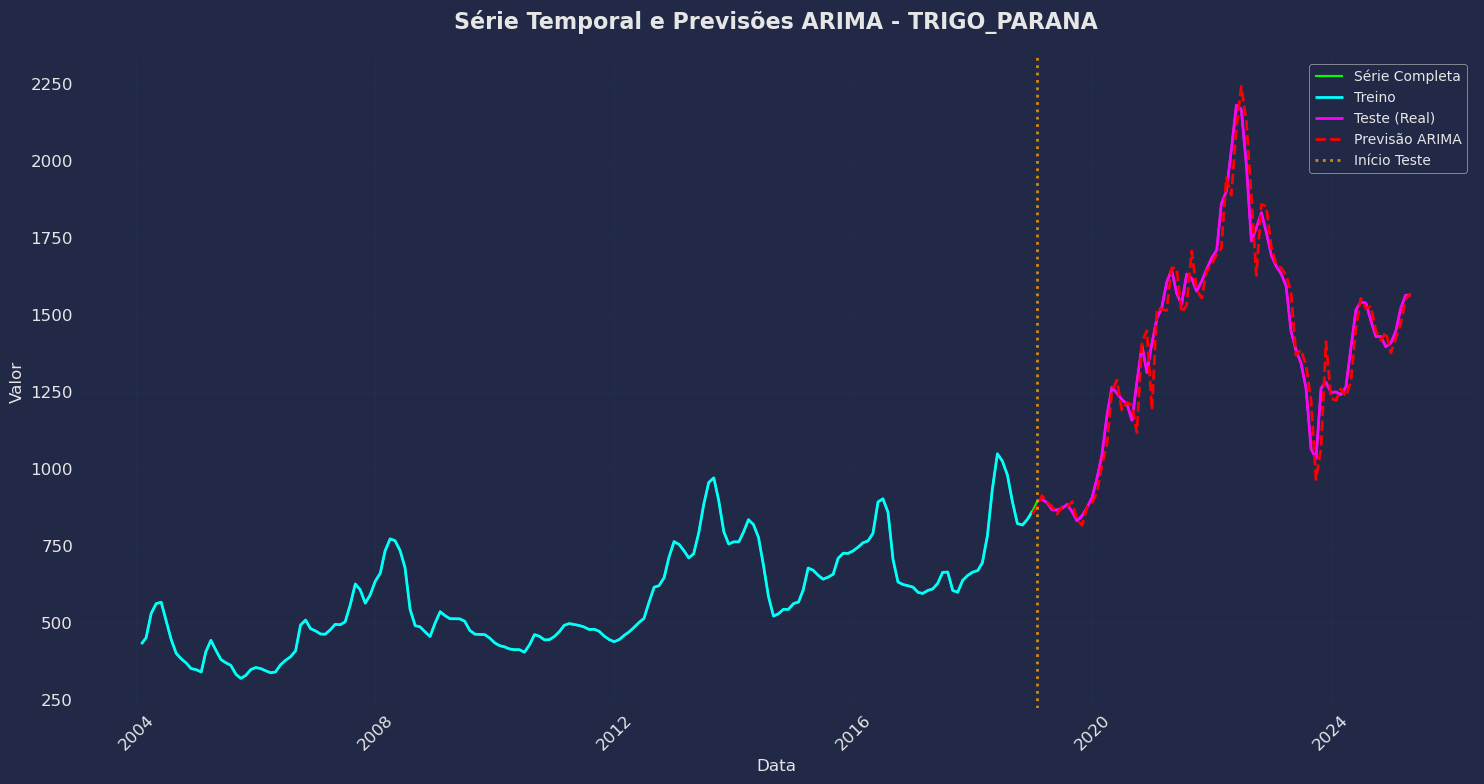

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


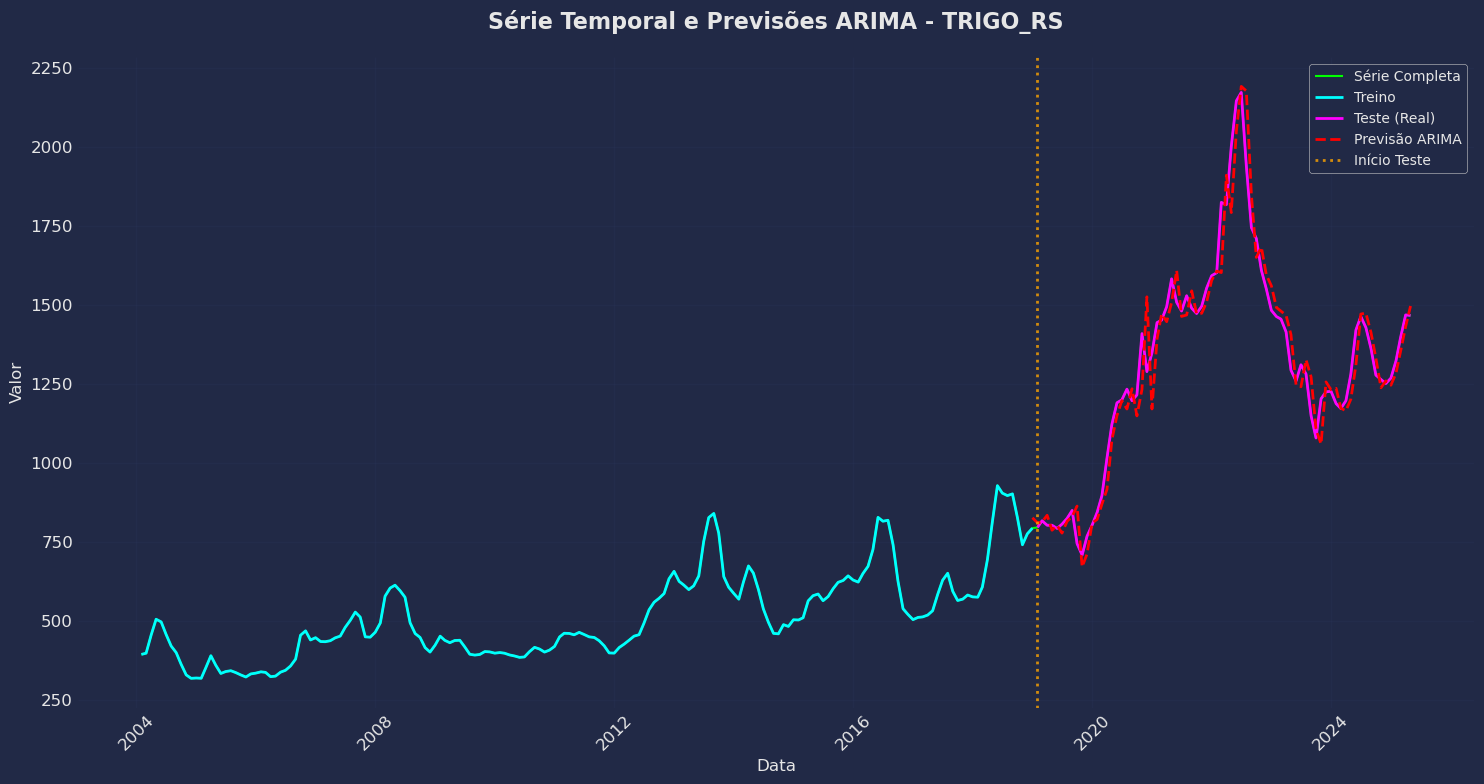

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [33]:
def plot_series_and_forecasts_arima(df_brl, results, ratio=0.3):
    """
    Plota a série completa, treino, teste e previsões one-step do ARIMA
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        # Série completa
        series_data = df_brl[df_brl['unique_id'] == uid].copy().sort_values("ds")
        N = len(series_data)
        H = max(1, int(N * ratio))
        train_data = series_data.iloc[:-H]
        test_data = series_data.iloc[-H:]
        
        # Previsões geradas no rollout
        forecast_data = results[results['unique_id'] == uid].copy().sort_values("ds")
        
        # === Plots ===
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['y_pred'], 
                color='red', linewidth=2, linestyle='--', label='Previsão ARIMA')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        # Configurações visuais
        ax.set_title(f'Série Temporal e Previsões ARIMA - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Valor', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)


plot_series_and_forecasts_arima(df_brl, results, ratio=0.3)